# Outlier Detection

In [35]:
%%capture
%run ./HDBSCAN_algorithm.ipynb

While clustering algorithms typically focus on grouping similar points, **HDBSCAN*** offers a powerful, integrated framework for detecting anomalies. Unlike standard density-based methods (like DBSCAN) that simply classify points as "noise" if they don't fit, HDBSCAN* calculates a continuous score for every point in the dataset, quantifying *how much* of an outlier it is.

This section implements the **GLOSH (Global-Local Outlier Score from Hierarchies)** algorithm, described as **Algorithm 4** in the original paper.

---


## The GLOSH Algorithm

**GLOSH** unifies the concepts of "Global" and "Local" outliers into a single measure.
* **Global Outliers:** Points that are in low-density regions compared to the entire dataset.
* **Local Outliers:** Points that might be in a denser region than global outliers, but are still significantly less dense than their immediate neighbors (e.g., a point floating near a very dense cluster).

### Formula
For every point $x$, we calculate the outlier score $s_{GLOSH}(x)$ using the following measures derived from the hierarchy:

* $\epsilon(x)$: The distance scale (density threshold) at which point $x$ becomes disconnected from a cluster (becomes noise).
* $\epsilon_{max}(c(x))$: The distance scale at which the cluster $x$ belongs to "dies" (either splits or drops below the minimum size).

The score is defined as:

$$
GLOSH(x) = 1 - \frac{\epsilon_{max}(c(x))}{\epsilon(x)}
$$

### Interpretation
* **Score $\approx$ 0:** The point disconnects at nearly the same scale that its cluster dies. It is a core part of the cluster (**Inlier**).
* **Score $\approx$ 1:** The point disconnects very early (at a high distance/low density), while its associated cluster persists much longer (into high densities). It is an **Outlier**.


### Algorithm

Here is represented the original algorithm:

> **ALGORITHM 4: Main steps for computing GLOSH scores**

> 1. While building the HDBSCAN* clustering hierarchy top-down, keep track and store the following information for each object $x_i$:
>     * The last cluster, say $C_j$, to which object $x_i$ belongs top-down through the hierarchy, that is, before it becomes noise.
>     * The lowest radius $\varepsilon$, denoted herein as $\varepsilon(x_i)$, at which $x_i$ still belongs to cluster $C_j$ (and below which $x_i$ is labeled as noise).
>     * The lowest radius $\varepsilon$, denoted herein as $\varepsilon_{\max(x_i)}$, at which cluster $C_j$ or any of its subclusters still exist (and below which all its objects are labeled as noise).
> 2. For each object $x_i$ do:
>     1. Compute $GLOSH(x_i)$ with the values $\varepsilon(x_i)$ and $\varepsilon_{\max(x_i)}$ from Step 1.

---

In order to compute the GLOSH scores, we must first modify the HDBSCAN* functions to save the information required by the algorithm.

In [36]:
def dendrogram(mst_ext, m_clSize=None):
    '''
    Construct a dendrogram from the extended MST.
    '''    

    n_points = mst_ext.shape[0]

    if m_clSize is None:
        m_clSize = m_pts
    
    # Initialize Graph from MST_ext
    G = nx.Graph()
    G.add_nodes_from(range(n_points))
    edges = []
    for i in range(n_points):
        for j in range(i, n_points):
            w = mst_ext[i, j]
            if w < np.inf: 
                G.add_edge(i, j, weight=w)
                edges.append((i, j, w))
    
    # Sort edges by weight in decreasing order
    unique_weights = sorted(list(set(w for u, v, w in edges)), reverse=True)
    
    # Initialize lists to store scales and number of clusters
    hierarchy = []
    hierarchy.append({
        'scale': np.inf,
        'n_clusters': 1,
        'labels': np.ones(n_points, dtype=int)
    })

    # GLOSH Initializations
    # The scale at which point x becomes noise
    epsilon_x = np.zeros(n_points) 
    
    # The ID of the last valid cluster x belonged to
    last_cluster_id = np.zeros(n_points, dtype=int)
    
    # Records the scale at which a cluster dies or splits
    cluster_death_scales = {}
    
    # Track lineage for min-propagation
    cluster_parents = {}

    # We assign initial cluster IDs based on the full MST connectivity
    initial_components = list(nx.connected_components(G))
    current_labels = np.zeros(n_points, dtype=int)
    next_cluster_id = 1
    
    # Assign initial labels
    for comp in initial_components:
        if len(comp) >= m_clSize:
            current_labels[list(comp)] = next_cluster_id
            next_cluster_id += 1
        else:
            epsilon_x[list(comp)] = np.inf

    # Iteratively remove all edges
    for scale in unique_weights:

        # Set dendrogram scale value
        
        # Identify edges to remove
        edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] == scale]

        affected_nodes = set()
        for u, v in edges_to_remove:
            affected_nodes.add(u)
            affected_nodes.add(v)

        G.remove_edges_from(edges_to_remove)

        # Find which original clusters were touched
        affected_cluster_ids = set(current_labels[list(affected_nodes)])

        # Ignore noise (0)
        affected_cluster_ids.discard(0) 
        
        # Process only the affected clusters
        for parent_id in affected_cluster_ids:
            
            # Get all nodes currently belonging to this parent cluster
            parent_mask = (current_labels == parent_id)
            parent_nodes = np.where(parent_mask)[0]
            
            # Find the connected sub-components of this cluster in the current graph
            subgraph = G.subgraph(parent_nodes)
            sub_components = list(nx.connected_components(subgraph))
            
            # Classify sub-components as "Valid" or "Spurious"
            valid_sub_comps = []
            spurious_sub_comps = []
            
            for comp in sub_components:
                if len(comp) >= m_clSize:
                    valid_sub_comps.append(list(comp))
                else:
                    spurious_sub_comps.append(list(comp))
        
            # Label spurious subcomponents as noise
            for comp in spurious_sub_comps:
                comp_array = np.array(comp)
                current_labels[comp_array] = 0
                epsilon_x[comp_array] = scale
            
            num_valid = len(valid_sub_comps)
            
            # If all subcomponents are spurious -> Cluster has disappeared
            if num_valid == 0:
                cluster_death_scales[parent_id] = scale
                
            # If single subcomponent is not spurious -> Keep original label (Shrunk)
            elif num_valid == 1:
                # The valid component keeps 'parent_id'.
                # The nodes in valid_sub_comps[0] are already labeled 'parent_id',
                # so we do nothing. Spurious ones were set to 0 in step A.
                pass
                
            # If two or more are not spurious -> "True" cluster split
            else:
                cluster_death_scales[parent_id] = scale
                # Assign new labels to each valid subcomponent
                for comp in valid_sub_comps:
                    current_labels[comp] = next_cluster_id

                    # Update GLOSH trackers for the points moving to new cluster
                    last_cluster_id[comp] = next_cluster_id
                    
                    # Record lineage
                    cluster_parents[next_cluster_id] = parent_id

                    next_cluster_id += 1
                    
        # Record the state at this scale
        active_clusters = len(np.unique(current_labels[current_labels > 0]))
        
        hierarchy.append({
            'scale': scale,
            'labels': current_labels.copy(),
            'n_clusters': active_clusters
        })

    # GLOSH Post-Processing
    # Initialize with local death scales (0 if active until end)
    final_cluster_max_eps = {cid: cluster_death_scales.get(cid, 0.0) 
                             for cid in range(1, next_cluster_id)}

    # Propagate min scale from children to parents
    # We iterate in reverse ID order (children always have higher IDs than parents)
    for cid in range(next_cluster_id - 1, 0, -1):
        parent = cluster_parents.get(cid)
        if parent is not None:
            # The parent survives as long as its longest-lived child
            final_cluster_max_eps[parent] = min(final_cluster_max_eps[parent], 
                                                final_cluster_max_eps[cid])

    # Map cluster epsilon_max to points
    # GLOSH Equation (8): 1 - (epsilon_max(x) / epsilon(x))
    point_epsilon_max = np.zeros(n_points)
    for i in range(n_points):
        cluster = last_cluster_id[i]
        if cluster > 0:
            point_epsilon_max[i] = final_cluster_max_eps[cluster]
        else:
            # Points that never belonged to a cluster (always noise)
            point_epsilon_max[i] = 0.0 

    glosh_data = {
        'epsilon_x': epsilon_x,
        'epsilon_max': point_epsilon_max,
        'last_cluster_id': last_cluster_id
    }

    return hierarchy, glosh_data

def hdbscan(X, m_pts, m_clSize=None, evolution=False, verbose=False):
    '''
    Perform HDBSCAN* clustering on dataset X with parameter m_pts.
    '''

    # Compute the core distance w.r.t. m_pts for all data objects in X
    dists = core_distances(X, m_pts)
    if verbose:
        print("Core Distances:\n", dists)

    # Compute an MST of G_m_pts, the Mutual Reachability Graph.
    G_m_pts = mutual_reachability_graph(X, dists)
    mst = minimum_spanning_tree(G_m_pts)
    if verbose:
        print("\nMutual Reachability Graph:\n", G_m_pts)
        draw_mst(X, mst)

    # Extend the MST to obtain MST_ext, by adding for each vertex a “self edge” with the core distance of the corresponding object as weight.
    mst_ext = extend_mst(mst, dists)
    if verbose:
        print("\nExtended MST (MST_ext):\n", mst_ext)
    
    # Extract the HDBSCAN* hierarchy as a dendrogram from MST_ext
    hierarchy, glosh_data = dendrogram(mst_ext, m_clSize)
    if verbose or evolution:
        plot_cluster_evolution(hierarchy)

    return hierarchy, glosh_data

Now we can code the function that computes the GLOSH score for each point. It is important to note that the complexity of this function is $O(n)$.

In [37]:
def compute_glosh_scores(glosh_data):
    '''
    Compute Global-Local Outlier Scores from Hierarchies (GLOSH)
    '''
    epsilon_x = glosh_data['epsilon_x']
    epsilon_max = glosh_data['epsilon_max']
    
    n_points = len(epsilon_x)
    scores = np.zeros(n_points)
    
    # Iterate to handle edge cases safely (division by zero/infinity)
    for i in range(n_points):
        eps_x = epsilon_x[i]
        eps_max = epsilon_max[i]
        
        # Case 1: Point is isolated (infinite distance to nearest neighbor)
        if np.isinf(eps_x):
            scores[i] = 1.0
            
        # Case 2: Point coincides with cluster core (infinite density/zero distance)
        # If eps_x is 0, eps_max must also be 0. It's a perfect inlier.
        elif eps_x == 0:
            scores[i] = 0.0
            
        # Case 3: Standard calculation
        else:
            scores[i] = 1.0 - (eps_max / eps_x)
            
    # Clip scores to [0, 1] to handle potential floating point precision errors
    return np.clip(scores, 0.0, 1.0)

To test the implementation, we generate a synthetic dataset based on **Figure 10** from the original HDBSCAN paper. This dataset is specifically designed to challenge outlier detection algorithms by incorporating **varying densities**.

We generate **617 points** total, consisting of:

*  Three Gaussian Clusters (200 points each) of different densities.
*  17 Ground-Truth Outliers:
    * **Global Outliers:** Points scattered far away from any cluster (mostly to the right). These are "obvious" anomalies.
    * **Local Outliers:** Points located near the clusters but not *inside* them..

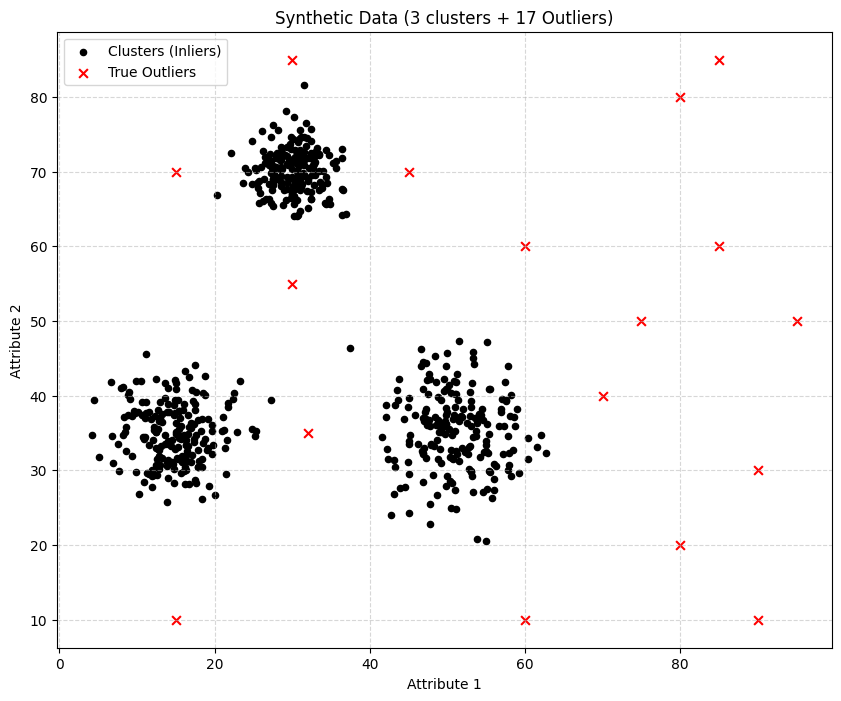

In [38]:
# RANDOM DATA GENERATION (3 CLUSTERS + 17 OUTLIERS)

np.random.seed(42)
data = []
    
# Generate Clusters 
c1 = np.random.normal(loc=[30, 70], scale=3.0, size=(200, 2))
data.append(c1)
c2 = np.random.normal(loc=[15, 35], scale=4.0, size=(200, 2))
data.append(c2)
c3 = np.random.normal(loc=[50, 35], scale=5.0, size=(200, 2))
data.append(c3)

# Generate Outliers
outliers = []

# 4 Local outliers around the dense cluster (C1)
outliers.append([30, 85]) # Top
outliers.append([30, 55]) # Bottom
outliers.append([15, 70]) # Left
outliers.append([45, 70]) # Right

# 1 Outlier "in-between" the two less dense clusters (C2 and C3)
outliers.append([32, 35])

# 1 "Questionable" local outlier at the bottom of lower-left cluster (C2)
outliers.append([15, 10])

# Global outliers (scattered, mostly to the right)
global_outliers = [
    [80, 80], [85, 85], [90, 10], [95, 50], [80, 20],
    [70, 40], [60, 60], [75, 50], [90, 30], [85, 60],
    [60, 10]
]
outliers.extend(global_outliers)
outliers = np.array(outliers)

# Combine all data
X = np.vstack(data + [outliers])
    

# Plot the generated data
plt.figure(figsize=(10, 8))
plt.scatter(X[:600, 0], X[:600, 1], c='black', s=20, label='Clusters (Inliers)')
plt.scatter(X[600:, 0], X[600:, 1], c='red', s=40, marker='x', label='True Outliers')
plt.title("Synthetic Data (3 clusters + 17 Outliers)")
plt.xlabel("Attribute 1")
plt.ylabel("Attribute 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Applying the GLOSH algorithm on this dataset:

In [39]:
m_pts = 10
hierarchy, glosh_data = hdbscan(X, m_pts, evolution=False, verbose=False)
print("GLOSH Data:")
print(glosh_data)

scores = compute_glosh_scores(glosh_data)
print("Outlier Scores (GLOSH):")
for i, score in enumerate(scores[:10]):
    print(f"Point {i}: {score:.4f}")

GLOSH Data:
{'epsilon_x': array([ 1.08478691,  1.89704491,  1.11293236,  1.81252815,  0.96290282,
        1.07261428,  2.38302932,  2.20317737,  0.90603423,  2.02736411,
        1.8346304 ,  1.3838049 ,  1.00620587,  1.06285837,  0.89832887,
        2.53715549,  1.12762282,  1.96507502,  2.49143723,  1.4285171 ,
        1.19020862,  1.15429966,  1.94211933,  1.25134517,  2.12982279,
        0.82132287,  1.03675459,  1.43349054,  0.89832887,  1.21273075,
        0.95643   ,  1.92139295,  1.62865036,  1.1974031 ,  0.86286548,
        1.4591491 ,  1.68682872,  4.31393917,  0.87330771,  2.4857993 ,
        0.93437631,  1.87489434,  0.89832887,  1.21060157,  1.05925451,
        1.12046392,  0.89832887,  1.7927574 ,  1.08130772,  1.00509922,
        1.79449971,  1.3104614 ,  0.96388741,  2.66924628,  1.01313284,
        2.34511415,  3.0324359 ,  0.90260662,  1.25168656,  1.26029772,
        1.53687521,  2.35604804,  2.64846638,  1.12317659,  0.82132287,
        1.77387135,  1.09882829,  2.32

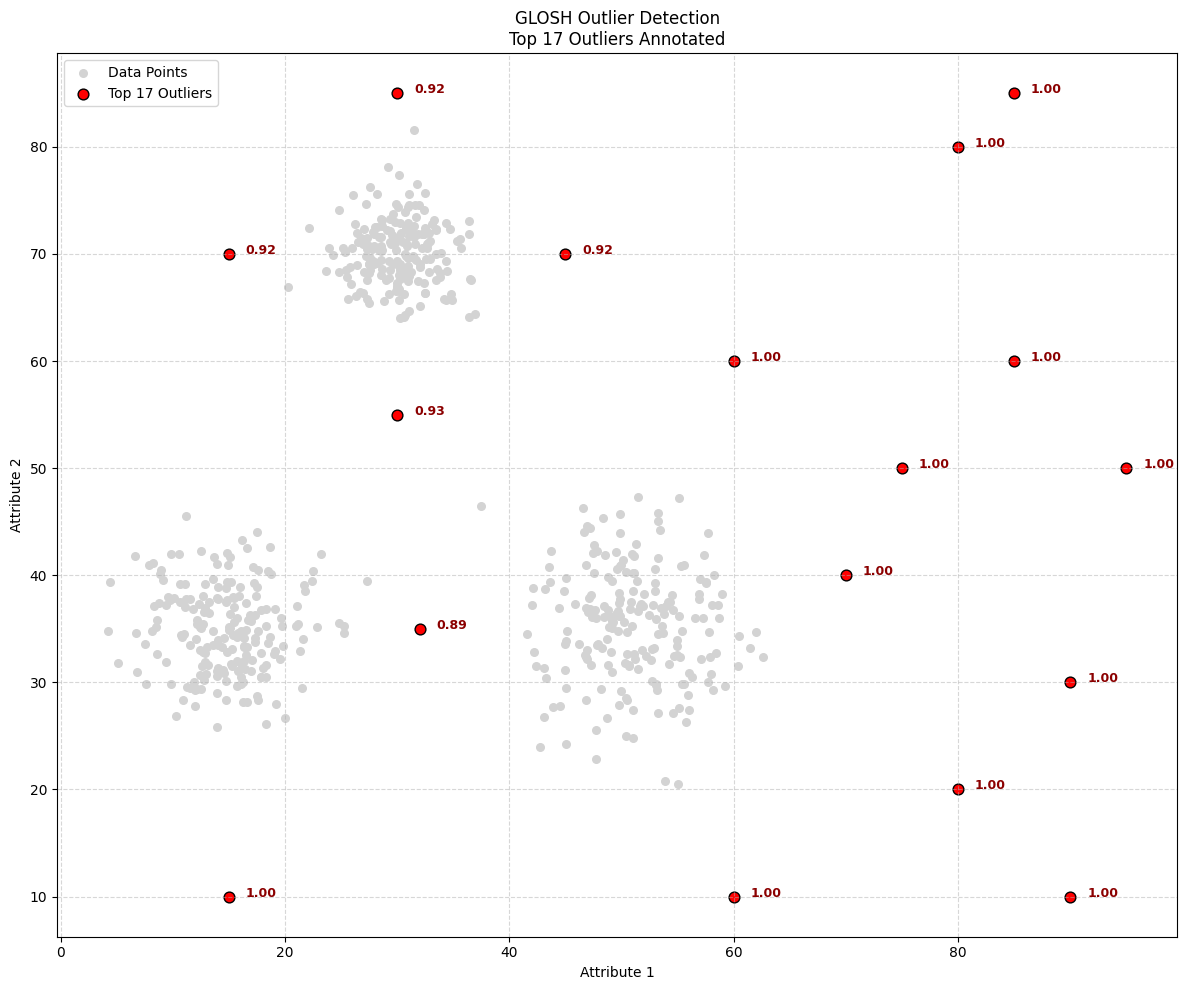

In [41]:
# Sort scores to find the indices of the top N outliers
top_n = 17
top_indices = np.argsort(scores)[::-1][:top_n]

# Plotting the results with annotated outlier scores
plt.figure(figsize=(12, 10))
plt.scatter(X[:, 0], X[:, 1], c='lightgrey', s=30, label='Data Points')
plt.scatter(X[top_indices, 0], X[top_indices, 1], c='red', s=60, edgecolors='k', label=f'Top {top_n} Outliers')
for idx in top_indices:
    plt.text(
        X[idx, 0] + 1.5,
        X[idx, 1],
        f'{scores[idx]:.2f}',
        fontsize=9,
        color='darkred',
        fontweight='bold'
    )
plt.title(f'GLOSH Outlier Detection\nTop {top_n} Outliers Annotated')
plt.xlabel('Attribute 1')
plt.ylabel('Attribute 2')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In the plot above, the points highlighted in **red** are the top 17 outliers detected by our GLOSH implementation.

* **Global Outliers:** The algorithm successfully detects the scattered points on the right side of the plot, assigning them scores close to `1.0`.
* **Local Outliers:** Crucially, it also detects the local outliers near the dense cluster (top left). Even though these points are geometrically closer to their neighbors than the points in the sparse clusters are to theirs, GLOSH correctly identifies that they are in a region of *relative* low density compared to the core they define.
* **Verification:** The top 17 detected points essentially match the 17 ground-truth outliers we inserted.